In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing import *
from custom_classes_defs_revised.unet0 import *

#from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
#from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-05 13:02:19.321480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 13:02:19.322326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 13:02:19.463588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 13:02:19.798349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Wed Jun  5 13:02:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   41C    P0             204W / 400W |  39536MiB / 40960MiB |     88%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   26C    P0              56W / 400W |    592MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0              62W / 400W |    592MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()

seis_path = '../data_thebe/seismic/'
label_path = '../data_thebe/fault/'
thebe_data = Thebe(seis_path,label_path)

# Create datasets for respective data samples and labels
x_test, y_test = thebe_data.data_generator(sub_group='test',as_numpy=True)
        
print("Size of test data: {}".format(thebe_data.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.49 minutes___


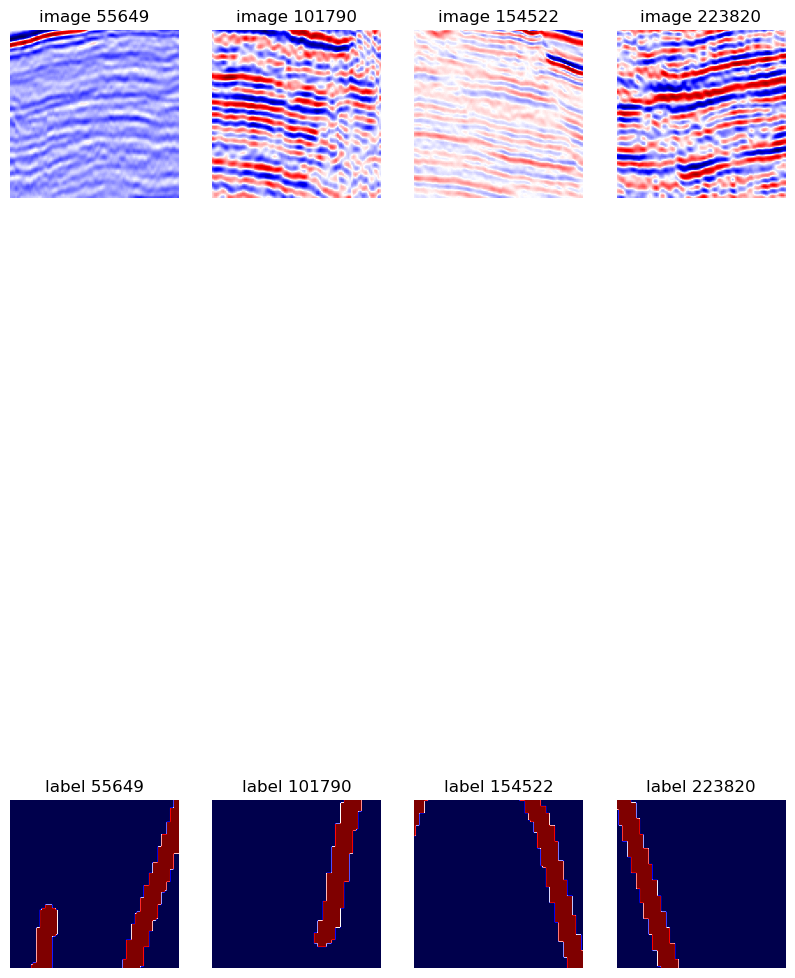

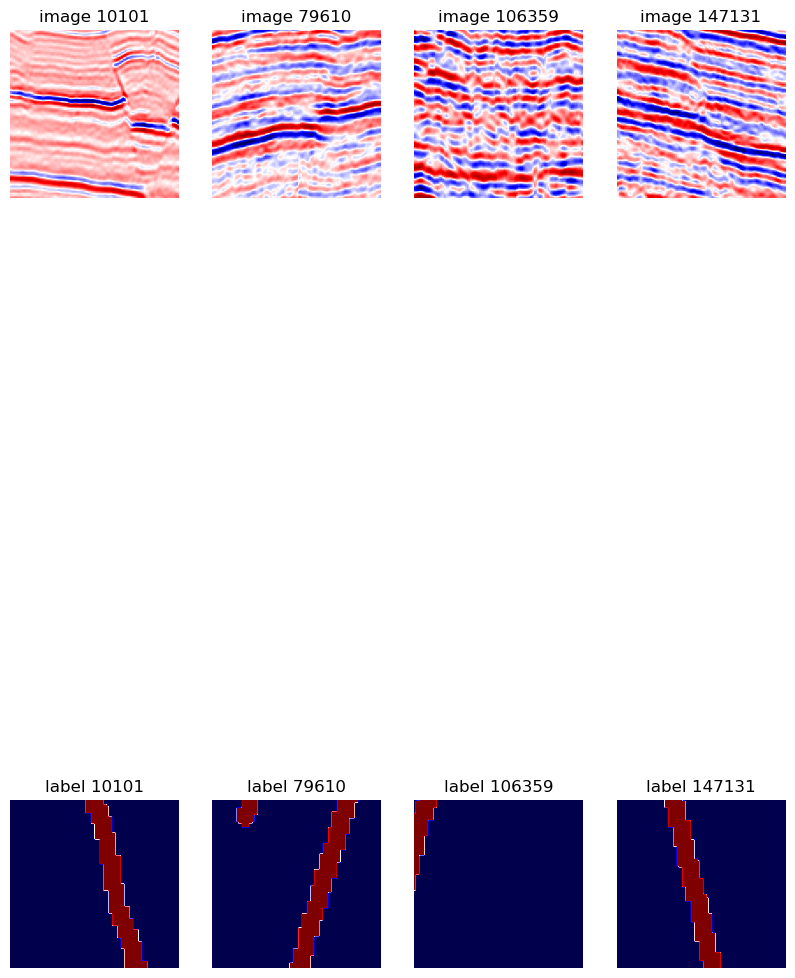

In [7]:
if INTERACTIVE_SESSION:
    thebe_data.display_sample_images(x_test, y_test, num_images=4)
    thebe_data.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/new/unet0',
    img_shape=thebe_data.img_size,
    target_size=thebe_data.img_size,
    threshold=thebe_data.threshold,
    pos_label=thebe_data.pos_label,
    train_size=thebe_data.train_size,
    test_size=thebe_data.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=thebe_data.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-06-05 13:03:42.190838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,145,953
Total trainable wieghts: 2,143,137
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
               

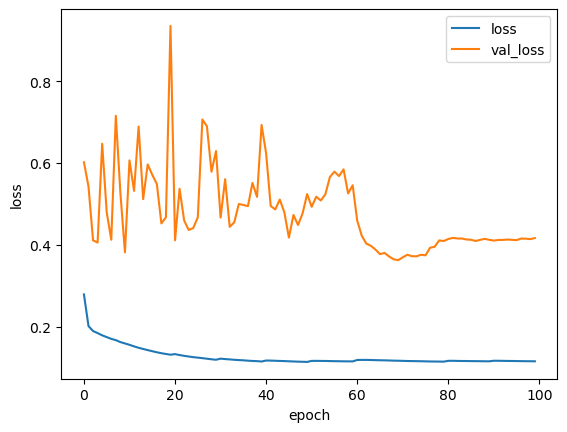

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


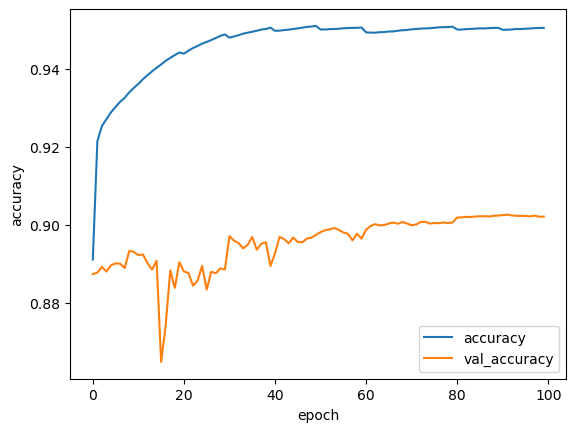

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

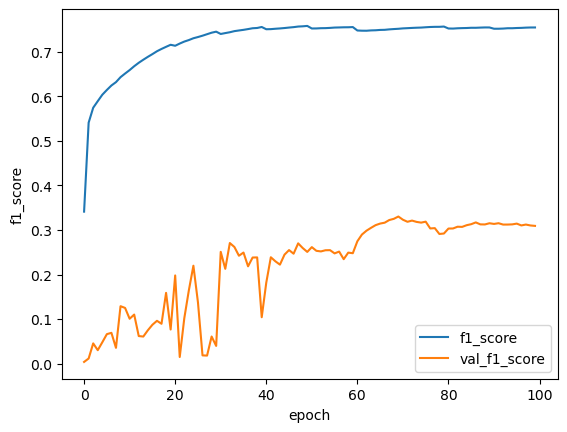

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

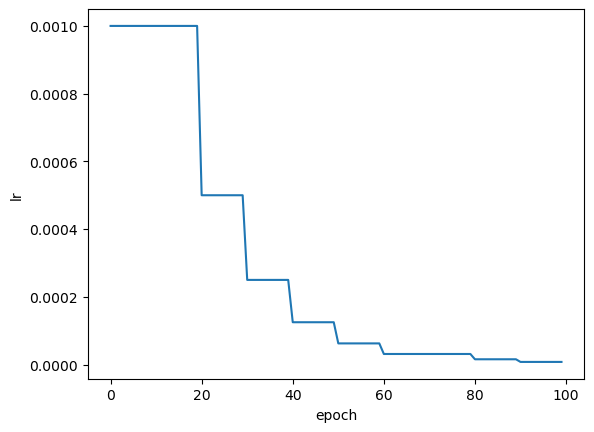

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate unet model
-------------------------------------------------------


2024-06-05 13:04:21.058520: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


  1/438 [..............................] - ETA: 1:34:22

  3/438 [..............................] - ETA: 18s    

  4/438 [..............................] - ETA: 23s

  5/438 [..............................] - ETA: 25s

  6/438 [..............................] - ETA: 26s

  7/438 [..............................] - ETA: 26s

  8/438 [..............................] - ETA: 26s

  9/438 [..............................] - ETA: 27s

 10/438 [..............................] - ETA: 27s

 11/438 [..............................] - ETA: 27s

 12/438 [..............................] - ETA: 27s

 13/438 [..............................] - ETA: 27s

 14/438 [..............................] - ETA: 27s

 15/438 [>.............................] - ETA: 27s

 16/438 [>.............................] - ETA: 27s

 17/438 [>.............................] - ETA: 27s

 18/438 [>.............................] - ETA: 27s

 19/438 [>.............................] - ETA: 27s

 20/438 [>.............................] - ETA: 27s

 21/438 [>.............................] - ETA: 27s

 22/438 [>.............................] - ETA: 27s

 23/438 [>.............................] - ETA: 27s

 24/438 [>.............................] - ETA: 27s

 25/438 [>.............................] - ETA: 27s

 26/438 [>.............................] - ETA: 27s

 27/438 [>.............................] - ETA: 27s

 28/438 [>.............................] - ETA: 27s

 29/438 [>.............................] - ETA: 27s

 30/438 [=>............................] - ETA: 27s

 31/438 [=>............................] - ETA: 27s

 32/438 [=>............................] - ETA: 26s

 33/438 [=>............................] - ETA: 26s

 34/438 [=>............................] - ETA: 26s

 35/438 [=>............................] - ETA: 26s

 36/438 [=>............................] - ETA: 26s

 37/438 [=>............................] - ETA: 26s

 38/438 [=>............................] - ETA: 26s

 39/438 [=>............................] - ETA: 26s

 40/438 [=>............................] - ETA: 26s

 41/438 [=>............................] - ETA: 26s

 42/438 [=>............................] - ETA: 26s

 43/438 [=>............................] - ETA: 26s

 44/438 [==>...........................] - ETA: 26s

 45/438 [==>...........................] - ETA: 26s

 46/438 [==>...........................] - ETA: 26s

 47/438 [==>...........................] - ETA: 26s

 48/438 [==>...........................] - ETA: 26s

 49/438 [==>...........................] - ETA: 25s

 50/438 [==>...........................] - ETA: 25s

 51/438 [==>...........................] - ETA: 25s

 52/438 [==>...........................] - ETA: 25s

 53/438 [==>...........................] - ETA: 25s

 54/438 [==>...........................] - ETA: 25s

 55/438 [==>...........................] - ETA: 25s

 56/438 [==>...........................] - ETA: 25s

 57/438 [==>...........................] - ETA: 25s

 58/438 [==>...........................] - ETA: 25s

 59/438 [===>..........................] - ETA: 25s

 60/438 [===>..........................] - ETA: 25s

 61/438 [===>..........................] - ETA: 25s

 62/438 [===>..........................] - ETA: 25s

 63/438 [===>..........................] - ETA: 25s

 64/438 [===>..........................] - ETA: 25s

 65/438 [===>..........................] - ETA: 24s

 66/438 [===>..........................] - ETA: 24s

 67/438 [===>..........................] - ETA: 24s

 68/438 [===>..........................] - ETA: 24s

 69/438 [===>..........................] - ETA: 24s

 70/438 [===>..........................] - ETA: 24s

 71/438 [===>..........................] - ETA: 24s

 72/438 [===>..........................] - ETA: 24s

 73/438 [====>.........................] - ETA: 24s

 74/438 [====>.........................] - ETA: 24s

 75/438 [====>.........................] - ETA: 24s

 76/438 [====>.........................] - ETA: 24s

 77/438 [====>.........................] - ETA: 24s

 78/438 [====>.........................] - ETA: 24s

 79/438 [====>.........................] - ETA: 24s

 80/438 [====>.........................] - ETA: 24s

 81/438 [====>.........................] - ETA: 23s

 82/438 [====>.........................] - ETA: 23s

 83/438 [====>.........................] - ETA: 23s

 84/438 [====>.........................] - ETA: 23s

 85/438 [====>.........................] - ETA: 23s

 86/438 [====>.........................] - ETA: 23s

 87/438 [====>.........................] - ETA: 23s

 88/438 [=====>........................] - ETA: 23s

 89/438 [=====>........................] - ETA: 23s

 90/438 [=====>........................] - ETA: 23s

 91/438 [=====>........................] - ETA: 23s

 92/438 [=====>........................] - ETA: 23s

 93/438 [=====>........................] - ETA: 23s

 94/438 [=====>........................] - ETA: 23s

 95/438 [=====>........................] - ETA: 23s

 96/438 [=====>........................] - ETA: 22s

 97/438 [=====>........................] - ETA: 22s

 98/438 [=====>........................] - ETA: 22s

 99/438 [=====>........................] - ETA: 22s

100/438 [=====>........................] - ETA: 22s

101/438 [=====>........................] - ETA: 22s

102/438 [=====>........................] - ETA: 22s

103/438 [======>.......................] - ETA: 22s

104/438 [======>.......................] - ETA: 22s

105/438 [======>.......................] - ETA: 22s

106/438 [======>.......................] - ETA: 22s

107/438 [======>.......................] - ETA: 22s

108/438 [======>.......................] - ETA: 22s

109/438 [======>.......................] - ETA: 22s

110/438 [======>.......................] - ETA: 22s

111/438 [======>.......................] - ETA: 21s

112/438 [======>.......................] - ETA: 21s

113/438 [======>.......................] - ETA: 21s

114/438 [======>.......................] - ETA: 21s

115/438 [======>.......................] - ETA: 21s

116/438 [======>.......................] - ETA: 21s

117/438 [=======>......................] - ETA: 21s

118/438 [=======>......................] - ETA: 21s

119/438 [=======>......................] - ETA: 21s

120/438 [=======>......................] - ETA: 21s

121/438 [=======>......................] - ETA: 21s

122/438 [=======>......................] - ETA: 21s

123/438 [=======>......................] - ETA: 21s

124/438 [=======>......................] - ETA: 21s

125/438 [=======>......................] - ETA: 21s

126/438 [=======>......................] - ETA: 20s

127/438 [=======>......................] - ETA: 20s

128/438 [=======>......................] - ETA: 20s

129/438 [=======>......................] - ETA: 20s

130/438 [=======>......................] - ETA: 20s

131/438 [=======>......................] - ETA: 20s

132/438 [========>.....................] - ETA: 20s

133/438 [========>.....................] - ETA: 20s

134/438 [========>.....................] - ETA: 20s

135/438 [========>.....................] - ETA: 20s

136/438 [========>.....................] - ETA: 20s

137/438 [========>.....................] - ETA: 20s

138/438 [========>.....................] - ETA: 20s

139/438 [========>.....................] - ETA: 20s

140/438 [========>.....................] - ETA: 20s

141/438 [========>.....................] - ETA: 19s

142/438 [========>.....................] - ETA: 19s

143/438 [========>.....................] - ETA: 19s

144/438 [========>.....................] - ETA: 19s

145/438 [========>.....................] - ETA: 19s

146/438 [=========>....................] - ETA: 19s

147/438 [=========>....................] - ETA: 19s

148/438 [=========>....................] - ETA: 19s

149/438 [=========>....................] - ETA: 19s

150/438 [=========>....................] - ETA: 19s

151/438 [=========>....................] - ETA: 19s

152/438 [=========>....................] - ETA: 19s

153/438 [=========>....................] - ETA: 19s

154/438 [=========>....................] - ETA: 19s

155/438 [=========>....................] - ETA: 19s

156/438 [=========>....................] - ETA: 18s

157/438 [=========>....................] - ETA: 18s

158/438 [=========>....................] - ETA: 18s

159/438 [=========>....................] - ETA: 18s

160/438 [=========>....................] - ETA: 18s

161/438 [==========>...................] - ETA: 18s

162/438 [==========>...................] - ETA: 18s

163/438 [==========>...................] - ETA: 18s

164/438 [==========>...................] - ETA: 18s

165/438 [==========>...................] - ETA: 18s

166/438 [==========>...................] - ETA: 18s

167/438 [==========>...................] - ETA: 18s

168/438 [==========>...................] - ETA: 18s

169/438 [==========>...................] - ETA: 18s

170/438 [==========>...................] - ETA: 18s

171/438 [==========>...................] - ETA: 17s

172/438 [==========>...................] - ETA: 17s

173/438 [==========>...................] - ETA: 17s

174/438 [==========>...................] - ETA: 17s

175/438 [==========>...................] - ETA: 17s

176/438 [===========>..................] - ETA: 17s

177/438 [===========>..................] - ETA: 17s

178/438 [===========>..................] - ETA: 17s

179/438 [===========>..................] - ETA: 17s

180/438 [===========>..................] - ETA: 17s

181/438 [===========>..................] - ETA: 17s

182/438 [===========>..................] - ETA: 17s

183/438 [===========>..................] - ETA: 17s

184/438 [===========>..................] - ETA: 17s

185/438 [===========>..................] - ETA: 17s

186/438 [===========>..................] - ETA: 16s

187/438 [===========>..................] - ETA: 16s

188/438 [===========>..................] - ETA: 16s

189/438 [===========>..................] - ETA: 16s

190/438 [============>.................] - ETA: 16s

191/438 [============>.................] - ETA: 16s

192/438 [============>.................] - ETA: 16s

193/438 [============>.................] - ETA: 16s

194/438 [============>.................] - ETA: 16s

195/438 [============>.................] - ETA: 16s

196/438 [============>.................] - ETA: 16s

197/438 [============>.................] - ETA: 16s

198/438 [============>.................] - ETA: 16s

199/438 [============>.................] - ETA: 16s

200/438 [============>.................] - ETA: 16s

201/438 [============>.................] - ETA: 15s

202/438 [============>.................] - ETA: 15s

203/438 [============>.................] - ETA: 15s

204/438 [============>.................] - ETA: 15s

205/438 [=============>................] - ETA: 15s

206/438 [=============>................] - ETA: 15s

207/438 [=============>................] - ETA: 15s

208/438 [=============>................] - ETA: 15s

209/438 [=============>................] - ETA: 15s

210/438 [=============>................] - ETA: 15s

211/438 [=============>................] - ETA: 15s

212/438 [=============>................] - ETA: 15s

213/438 [=============>................] - ETA: 15s

214/438 [=============>................] - ETA: 15s

215/438 [=============>................] - ETA: 15s

216/438 [=============>................] - ETA: 14s

217/438 [=============>................] - ETA: 14s

218/438 [=============>................] - ETA: 14s

219/438 [==============>...............] - ETA: 14s

220/438 [==============>...............] - ETA: 14s

221/438 [==============>...............] - ETA: 14s

222/438 [==============>...............] - ETA: 14s

223/438 [==============>...............] - ETA: 14s

224/438 [==============>...............] - ETA: 14s

225/438 [==============>...............] - ETA: 14s

226/438 [==============>...............] - ETA: 14s

227/438 [==============>...............] - ETA: 14s

228/438 [==============>...............] - ETA: 14s

229/438 [==============>...............] - ETA: 14s

230/438 [==============>...............] - ETA: 14s

231/438 [==============>...............] - ETA: 13s

232/438 [==============>...............] - ETA: 13s

233/438 [==============>...............] - ETA: 13s

234/438 [===============>..............] - ETA: 13s

235/438 [===============>..............] - ETA: 13s

236/438 [===============>..............] - ETA: 13s

237/438 [===============>..............] - ETA: 13s

238/438 [===============>..............] - ETA: 13s

239/438 [===============>..............] - ETA: 13s

240/438 [===============>..............] - ETA: 13s

241/438 [===============>..............] - ETA: 13s

242/438 [===============>..............] - ETA: 13s

243/438 [===============>..............] - ETA: 13s

244/438 [===============>..............] - ETA: 13s

245/438 [===============>..............] - ETA: 13s

246/438 [===============>..............] - ETA: 12s

247/438 [===============>..............] - ETA: 12s

248/438 [===============>..............] - ETA: 12s

249/438 [================>.............] - ETA: 12s

250/438 [================>.............] - ETA: 12s

251/438 [================>.............] - ETA: 12s

252/438 [================>.............] - ETA: 12s

253/438 [================>.............] - ETA: 12s

254/438 [================>.............] - ETA: 12s

255/438 [================>.............] - ETA: 12s

256/438 [================>.............] - ETA: 12s

257/438 [================>.............] - ETA: 12s

258/438 [================>.............] - ETA: 12s

259/438 [================>.............] - ETA: 12s

260/438 [================>.............] - ETA: 12s

261/438 [================>.............] - ETA: 11s

262/438 [================>.............] - ETA: 11s

263/438 [=================>............] - ETA: 11s

264/438 [=================>............] - ETA: 11s

265/438 [=================>............] - ETA: 11s

266/438 [=================>............] - ETA: 11s

267/438 [=================>............] - ETA: 11s

268/438 [=================>............] - ETA: 11s

269/438 [=================>............] - ETA: 11s

270/438 [=================>............] - ETA: 11s

271/438 [=================>............] - ETA: 11s

272/438 [=================>............] - ETA: 11s

273/438 [=================>............] - ETA: 11s

274/438 [=================>............] - ETA: 11s

275/438 [=================>............] - ETA: 10s

276/438 [=================>............] - ETA: 10s

277/438 [=================>............] - ETA: 10s

278/438 [==================>...........] - ETA: 10s

279/438 [==================>...........] - ETA: 10s

280/438 [==================>...........] - ETA: 10s

281/438 [==================>...........] - ETA: 10s

282/438 [==================>...........] - ETA: 10s

283/438 [==================>...........] - ETA: 10s

284/438 [==================>...........] - ETA: 10s

285/438 [==================>...........] - ETA: 10s

286/438 [==================>...........] - ETA: 10s

287/438 [==================>...........] - ETA: 10s

288/438 [==================>...........] - ETA: 10s

289/438 [==================>...........] - ETA: 10s

290/438 [==================>...........] - ETA: 9s 

291/438 [==================>...........] - ETA: 9s

292/438 [===================>..........] - ETA: 9s

293/438 [===================>..........] - ETA: 9s

294/438 [===================>..........] - ETA: 9s

295/438 [===================>..........] - ETA: 9s

296/438 [===================>..........] - ETA: 9s

297/438 [===================>..........] - ETA: 9s

298/438 [===================>..........] - ETA: 9s

299/438 [===================>..........] - ETA: 9s

300/438 [===================>..........] - ETA: 9s

301/438 [===================>..........] - ETA: 9s

302/438 [===================>..........] - ETA: 9s

303/438 [===================>..........] - ETA: 9s

304/438 [===================>..........] - ETA: 9s

305/438 [===================>..........] - ETA: 8s

306/438 [===================>..........] - ETA: 8s

307/438 [====================>.........] - ETA: 8s

308/438 [====================>.........] - ETA: 8s

309/438 [====================>.........] - ETA: 8s

310/438 [====================>.........] - ETA: 8s

311/438 [====================>.........] - ETA: 8s

312/438 [====================>.........] - ETA: 8s

313/438 [====================>.........] - ETA: 8s

314/438 [====================>.........] - ETA: 8s

315/438 [====================>.........] - ETA: 8s

316/438 [====================>.........] - ETA: 8s

317/438 [====================>.........] - ETA: 8s

318/438 [====================>.........] - ETA: 8s

319/438 [====================>.........] - ETA: 8s

320/438 [====================>.........] - ETA: 7s

321/438 [====================>.........] - ETA: 7s

322/438 [=====================>........] - ETA: 7s

323/438 [=====================>........] - ETA: 7s

324/438 [=====================>........] - ETA: 7s

325/438 [=====================>........] - ETA: 7s

326/438 [=====================>........] - ETA: 7s

327/438 [=====================>........] - ETA: 7s

328/438 [=====================>........] - ETA: 7s

329/438 [=====================>........] - ETA: 7s

330/438 [=====================>........] - ETA: 7s

331/438 [=====================>........] - ETA: 7s

332/438 [=====================>........] - ETA: 7s

333/438 [=====================>........] - ETA: 7s

334/438 [=====================>........] - ETA: 7s

335/438 [=====================>........] - ETA: 6s

336/438 [======================>.......] - ETA: 6s

337/438 [======================>.......] - ETA: 6s

338/438 [======================>.......] - ETA: 6s

339/438 [======================>.......] - ETA: 6s

340/438 [======================>.......] - ETA: 6s

341/438 [======================>.......] - ETA: 6s

342/438 [======================>.......] - ETA: 6s

343/438 [======================>.......] - ETA: 6s

344/438 [======================>.......] - ETA: 6s

345/438 [======================>.......] - ETA: 6s

346/438 [======================>.......] - ETA: 6s

347/438 [======================>.......] - ETA: 6s

348/438 [======================>.......] - ETA: 6s

349/438 [======================>.......] - ETA: 6s

350/438 [======================>.......] - ETA: 5s

351/438 [=======================>......] - ETA: 5s

352/438 [=======================>......] - ETA: 5s

353/438 [=======================>......] - ETA: 5s

354/438 [=======================>......] - ETA: 5s

355/438 [=======================>......] - ETA: 5s

356/438 [=======================>......] - ETA: 5s

357/438 [=======================>......] - ETA: 5s

358/438 [=======================>......] - ETA: 5s

359/438 [=======================>......] - ETA: 5s

360/438 [=======================>......] - ETA: 5s

361/438 [=======================>......] - ETA: 5s

362/438 [=======================>......] - ETA: 5s

363/438 [=======================>......] - ETA: 5s

364/438 [=======================>......] - ETA: 4s

365/438 [========================>.....] - ETA: 4s

366/438 [========================>.....] - ETA: 4s

367/438 [========================>.....] - ETA: 4s

368/438 [========================>.....] - ETA: 4s

369/438 [========================>.....] - ETA: 4s

370/438 [========================>.....] - ETA: 4s

371/438 [========================>.....] - ETA: 4s

372/438 [========================>.....] - ETA: 4s

373/438 [========================>.....] - ETA: 4s

374/438 [========================>.....] - ETA: 4s

375/438 [========================>.....] - ETA: 4s

376/438 [========================>.....] - ETA: 4s

377/438 [========================>.....] - ETA: 4s

378/438 [========================>.....] - ETA: 4s

379/438 [========================>.....] - ETA: 3s

380/438 [=========================>....] - ETA: 3s

381/438 [=========================>....] - ETA: 3s

382/438 [=========================>....] - ETA: 3s

383/438 [=========================>....] - ETA: 3s

384/438 [=========================>....] - ETA: 3s

385/438 [=========================>....] - ETA: 3s

386/438 [=========================>....] - ETA: 3s

387/438 [=========================>....] - ETA: 3s

388/438 [=========================>....] - ETA: 3s

389/438 [=========================>....] - ETA: 3s

390/438 [=========================>....] - ETA: 3s

391/438 [=========================>....] - ETA: 3s

392/438 [=========================>....] - ETA: 3s

393/438 [=========================>....] - ETA: 3s

394/438 [=========================>....] - ETA: 2s

395/438 [==========================>...] - ETA: 2s

396/438 [==========================>...] - ETA: 2s

397/438 [==========================>...] - ETA: 2s

398/438 [==========================>...] - ETA: 2s

399/438 [==========================>...] - ETA: 2s

400/438 [==========================>...] - ETA: 2s

401/438 [==========================>...] - ETA: 2s

402/438 [==========================>...] - ETA: 2s

403/438 [==========================>...] - ETA: 2s

404/438 [==========================>...] - ETA: 2s

405/438 [==========================>...] - ETA: 2s

406/438 [==========================>...] - ETA: 2s

407/438 [==========================>...] - ETA: 2s

408/438 [==========================>...] - ETA: 2s

409/438 [===========================>..] - ETA: 1s

410/438 [===========================>..] - ETA: 1s

411/438 [===========================>..] - ETA: 1s

412/438 [===========================>..] - ETA: 1s

413/438 [===========================>..] - ETA: 1s

414/438 [===========================>..] - ETA: 1s

415/438 [===========================>..] - ETA: 1s

416/438 [===========================>..] - ETA: 1s

417/438 [===========================>..] - ETA: 1s

418/438 [===========================>..] - ETA: 1s

419/438 [===========================>..] - ETA: 1s

420/438 [===========================>..] - ETA: 1s

421/438 [===========================>..] - ETA: 1s

422/438 [===========================>..] - ETA: 1s

423/438 [===========================>..] - ETA: 1s

424/438 [============================>.] - ETA: 0s

425/438 [============================>.] - ETA: 0s

426/438 [============================>.] - ETA: 0s

427/438 [============================>.] - ETA: 0s

428/438 [============================>.] - ETA: 0s

429/438 [============================>.] - ETA: 0s

430/438 [============================>.] - ETA: 0s

431/438 [============================>.] - ETA: 0s

432/438 [============================>.] - ETA: 0s

433/438 [============================>.] - ETA: 0s

434/438 [============================>.] - ETA: 0s

435/438 [============================>.] - ETA: 0s

436/438 [============================>.] - ETA: 0s

437/438 [============================>.] - ETA: 0s

438/438 [==============================] - ETA: 0s

438/438 [==============================] - 46s 75ms/step


evaluation elapsed time:___ 0.97___minutes


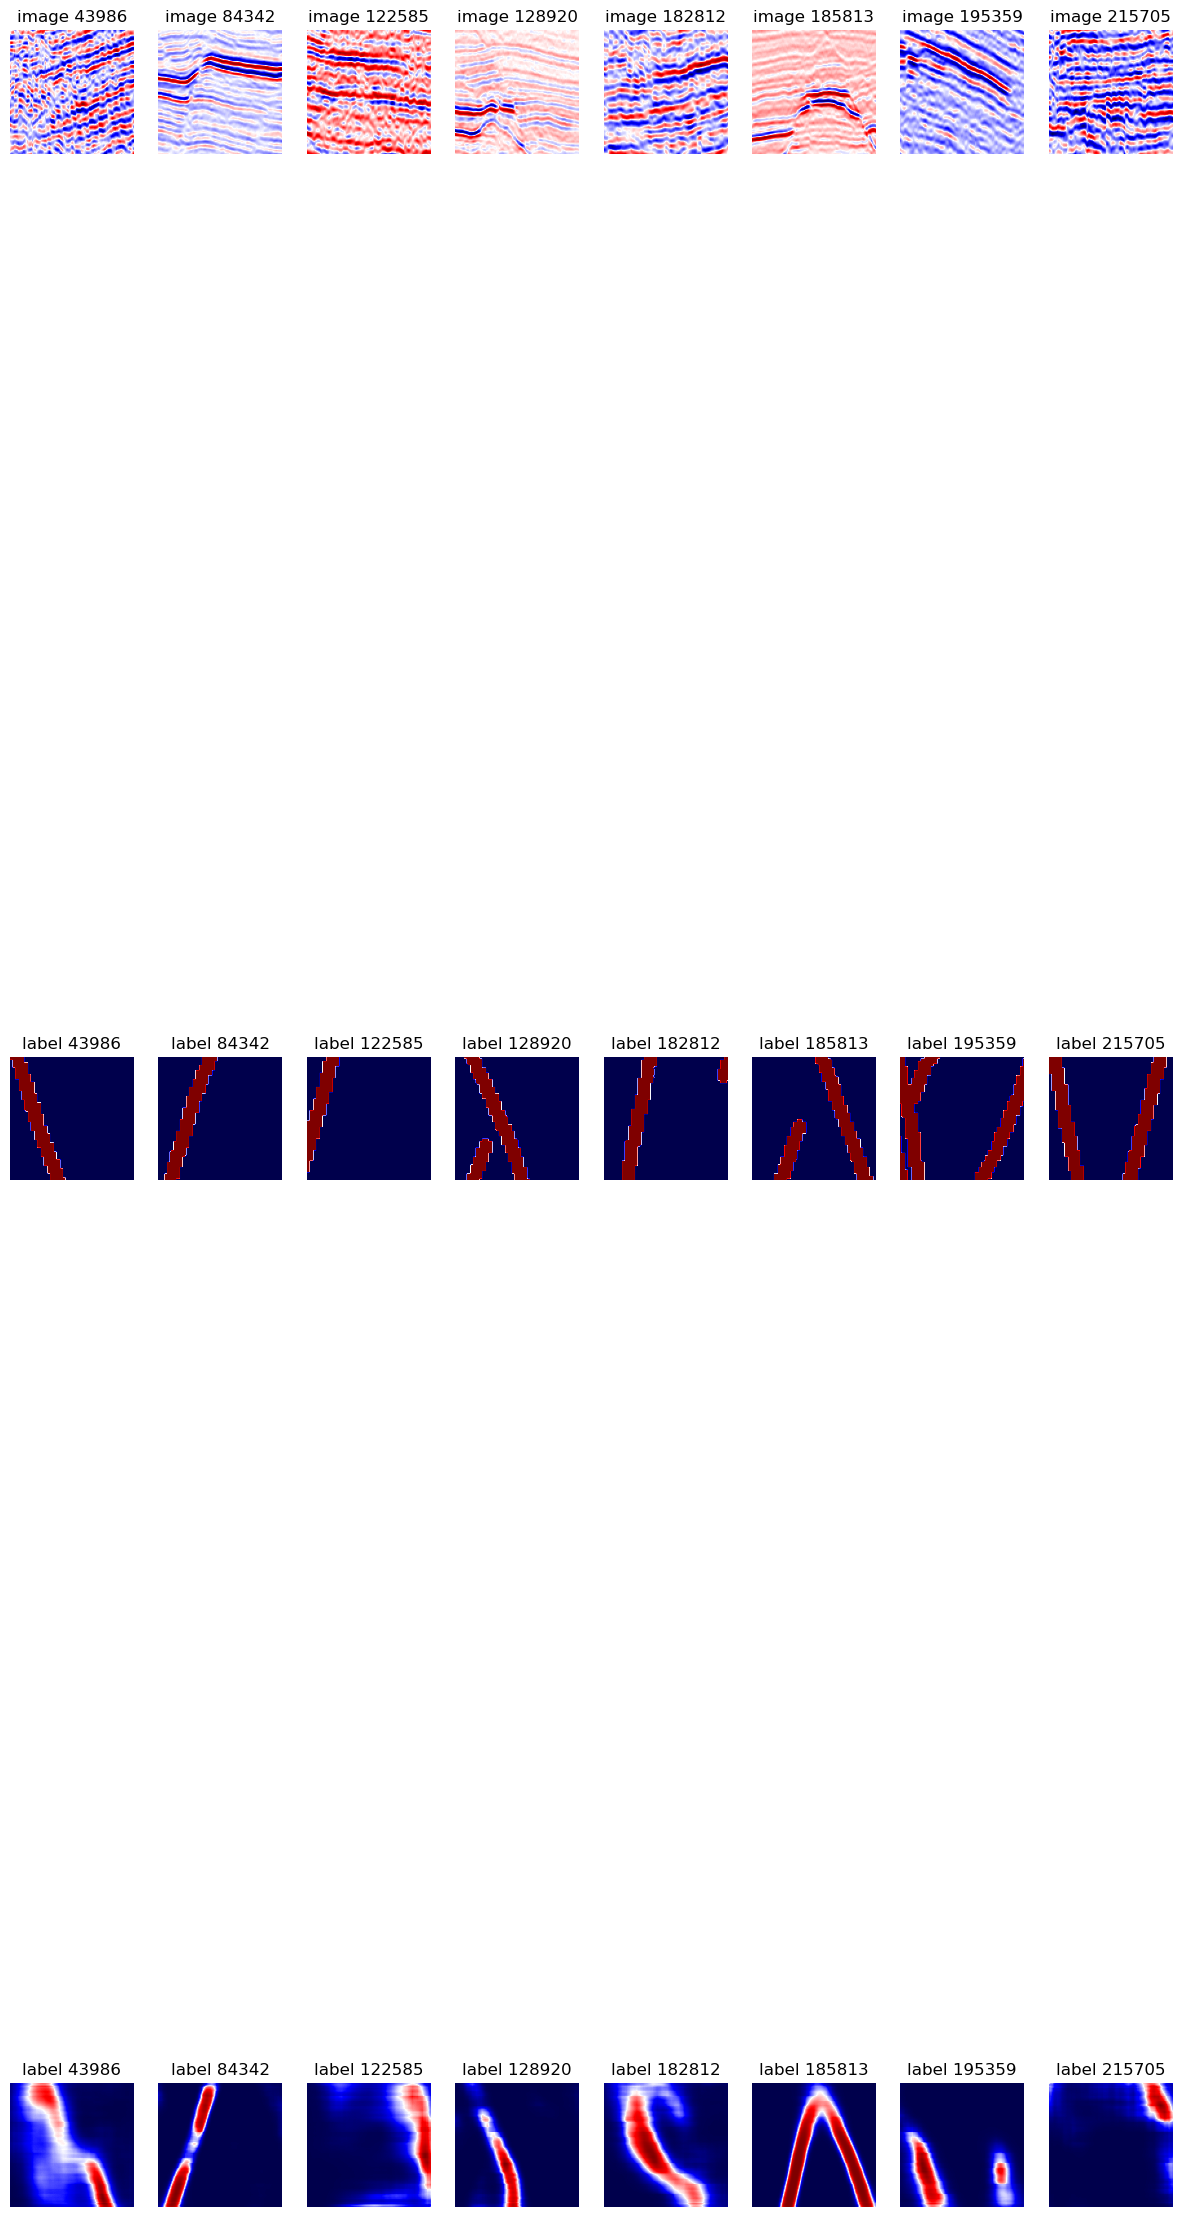

In [15]:

if INTERACTIVE_SESSION:
    thebe_data.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___111.79___minutes
                      0             1  accuracy     macro avg  weighted avg
precision  9.800000e-01  2.000000e-01      0.59  5.900000e-01  8.900000e-01
recall     5.500000e-01  9.000000e-01      0.59  7.200000e-01  5.900000e-01
f1-score   7.000000e-01  3.200000e-01      0.59  5.100000e-01  6.600000e-01
support    1.841265e+09  2.242436e+08      0.59  2.065508e+09  2.065508e+09
{'Avg-precision': 0.5, 'f1-score(ODS)': 0.32}
